# **[SF-DST] Credit Scoring** <br>
### Прогнозирование вероятности дефолта заемщика

## Задача:
Построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно определить значимые параметры заемщика. <br>
Результаты оцениваются по площади под кривой ROC AUC.

Соревнование на Kaggle: [[SF-DST] Credit Scoring](https://www.kaggle.com/c/sf-dst-scoring/)


### Импорт библиотек

In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [71]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [72]:
data_train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
data_test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv') 

In [73]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
data_train['Train'] = 1 # помечаем где у нас трейн
data_test['Train'] = 0 # помечаем где у нас тест

data = data_train.append(data_test, sort=False).reset_index(drop=True) # объединяем

### Данные:

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

### Диаграмма для переменной 'default':

<AxesSubplot:xlabel='default', ylabel='count'>

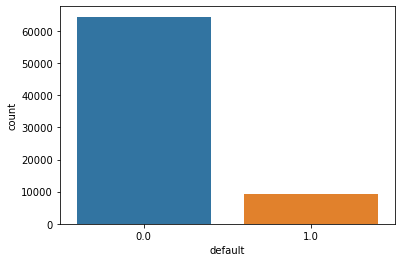

In [74]:
sns.countplot(x='default', data=data)

In [75]:
data['default'].value_counts()

0.0    64427
1.0     9372
Name: default, dtype: int64

Дефолтных клиентов намного меньше чем недефолтных.

### Информация о данных и наличие пропусков:

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [77]:
data.isnull().sum() #наличие пропусков в объединенном датасете

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

In [78]:
data[data['Train'] == 1].isnull().sum() # наличие пропусков только в тренировочном датасете

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
Train                 0
dtype: int64

Пропуски в ***'defalt'*** есть только в тренировочном датасете, т.к. этот признак мы и должны предсказать. <br>
Пропуски в ***'education'*** мы должны заполнить.

### Признак 'education':

<AxesSubplot:>

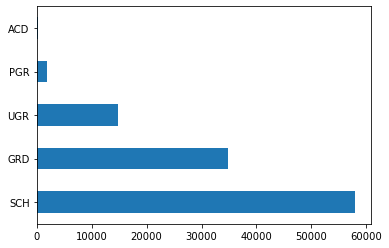

In [79]:
data['education'].value_counts().plot.barh()

Заполним пропуски наиболее частым значением. Этот способ оказался самым эффективным на практике:

In [80]:
data['education'] = data['education'].fillna('SCH')

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа:

In [81]:
# разобъем данные по категориям
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address',  'sna', 'first_time', 'region_rating']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

## **Числовые переменные**

Распределение числовых данных:

<AxesSubplot:title={'center':"Распределение по признаку 'score_bki'"}, ylabel='Frequency'>

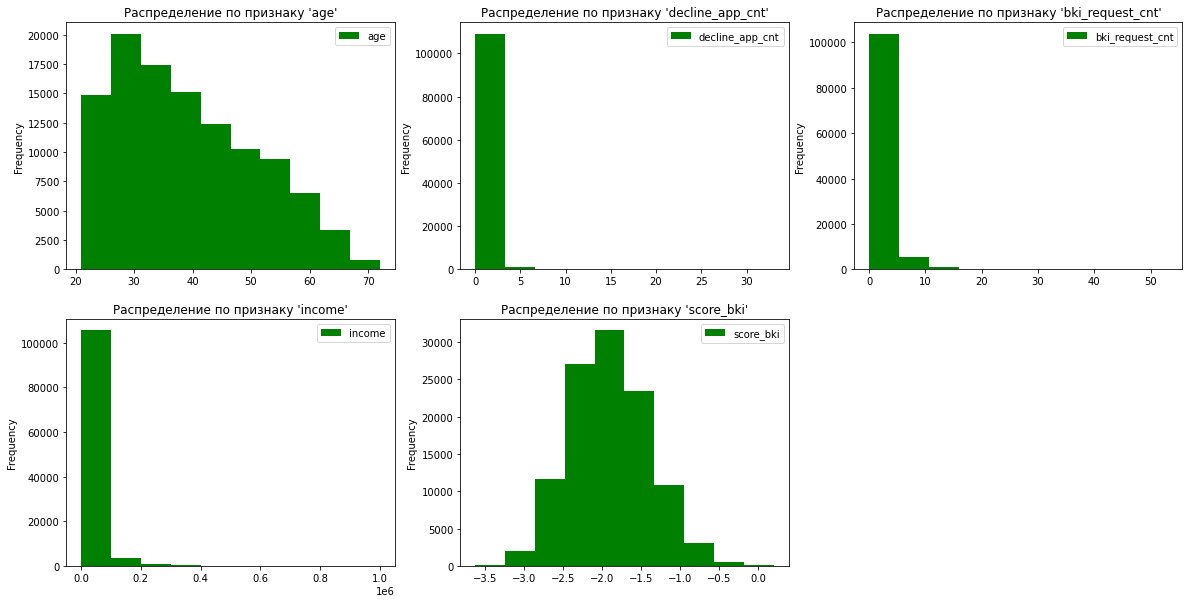

In [82]:
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(2, 3, 1)
ax_2 = fig.add_subplot(2, 3, 2)
ax_3 = fig.add_subplot(2, 3, 3)
ax_4 = fig.add_subplot(2, 3, 4)
ax_5 = fig.add_subplot(2, 3, 5)

data.plot(y='age', kind='hist', color='green', title="Распределение по признаку 'age'", ax=ax_1)
data.plot(y='decline_app_cnt', kind='hist', color='green', title="Распределение по признаку 'decline_app_cnt'", ax=ax_2)
data.plot(y='bki_request_cnt', kind='hist', color='green', title="Распределение по признаку 'bki_request_cnt'", ax=ax_3)
data.plot(y='income', kind='hist', color='green', title="Распределение по признаку 'income'", ax=ax_4)
data.plot(y='score_bki', kind='hist', color='green', title="Распределение по признаку 'score_bki'", ax=ax_5)

Прологорифмируем признаки **'age'**, **'decline_app_cnt'**, **'bki_request_cnt'**, **'income'**, чтобы добиться более нормального распределения:

In [83]:
data_log = pd.DataFrame() # создадим вспомогательный датафрейм

data_log['log_age'] = np.log(data['age']+1)
data_log['log_decline_app_cnt'] = np.log(data['decline_app_cnt']+1)
data_log['log_bki_request_cnt'] = np.log(data['bki_request_cnt']+1)
data_log['log_income'] = np.log(data['income']+1)

Построим графики распределения логарифмированных переменных:

<AxesSubplot:title={'center':"Распределение по признаку 'log_income'"}, ylabel='Frequency'>

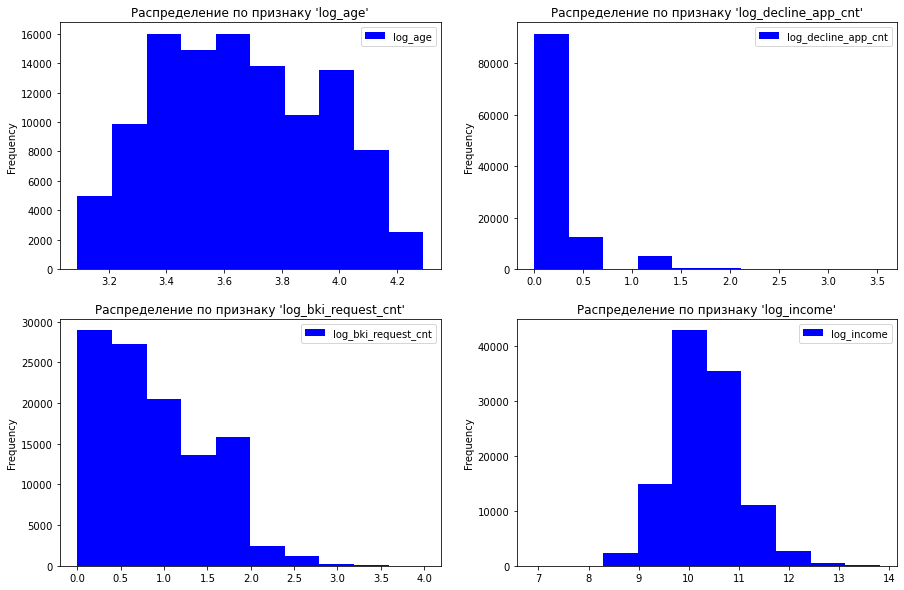

In [84]:
fig = plt.figure(figsize=(15, 10))

ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)
ax_3 = fig.add_subplot(2, 2, 3)
ax_4 = fig.add_subplot(2, 2, 4)

data_log.plot(y='log_age', kind='hist', color='blue', title="Распределение по признаку 'log_age'", ax=ax_1)
data_log.plot(y='log_decline_app_cnt', kind='hist', color='blue', title="Распределение по признаку 'log_decline_app_cnt'", ax=ax_2)
data_log.plot(y='log_bki_request_cnt', kind='hist', color='blue', title="Распределение по признаку 'log_bki_request_cnt'", ax=ax_3)
data_log.plot(y='log_income', kind='hist', color='blue', title="Распределение по признаку 'log_income'", ax=ax_4)

Распределение стало более нормальным, но как показала практика от этого не улучшилась наша метрика. Поэтому оставим исходные значения.

### Оценка корреляций <br>
Оценим корреляцию Пирсона для непрерывных переменных:

<AxesSubplot:>

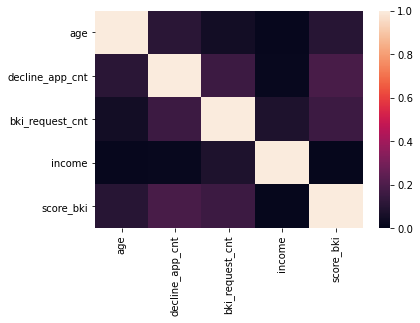

In [85]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Как мы видим из оценки, сильно коррелирующих между собой признаков нет.

### Значимость числовых переменных

<AxesSubplot:>

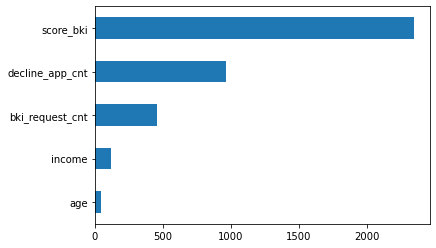

In [86]:
imp_num = Series(f_classif(data[num_cols][data['Train'] == 1], data_train['default'][data['Train'] == 1])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Признак **'score_bki'** оказался самым значимым из числовых.

### Преобразование числовых переменных и добавление новых признаков

Для улучшения метрики введем новые признаки. На практике позали хорошие результаты показали следующие преобразования:

In [87]:
# новые данные
data['income_brc'] = data['income']/(data['bki_request_cnt']+1) 
data['income_dac'] = data['income']/(data['decline_app_cnt']+1)

Рассмотрим по отдельности каждый числовой признак.

**age**

<AxesSubplot:xlabel='default', ylabel='age'>

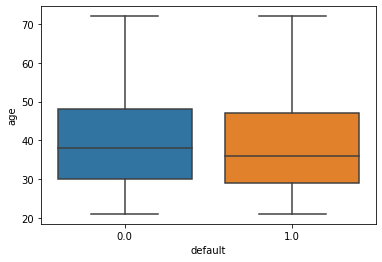

In [88]:
sns.boxplot(x='default', y='age', data=data[data['Train'] == 1])

Дефолтные клиенты в среднем младше.

**Как показали тесты, метрика улучшается, если перевести некоторые числовые признаки в категориальные.**

In [89]:
# перевод числового признака 'age' в категориальный с оптимальными параметрами разбиения

def age_to_cat(x):
    if x <= 25:
        return 1
    elif x <= 50:
        return 2
    else:
        return 3


data['age'] = data['age'].apply(age_to_cat) 

**decline_app_cnt**

<AxesSubplot:xlabel='default', ylabel='decline_app_cnt'>

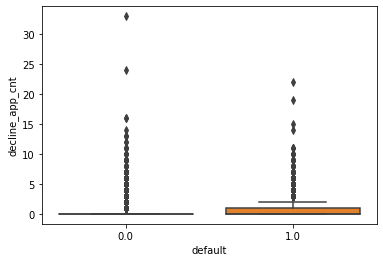

In [90]:
sns.boxplot(x='default', y='decline_app_cnt', data=data[data['Train'] == 1])

Дефолтные клиенты в среднем имеют большее количество отмененных заявок. Выбросы удалять не будем, так как будем переводить этот признак в категориальный.

In [91]:
# Значения равные больше двух объединим в одну категорию

def decline_app_cnt_to_cat(x):
    if x <= 2:
        return x
    else:
        return 3


data['decline_app_cnt'] = data['decline_app_cnt'].apply(decline_app_cnt_to_cat)

**bki_request_cnt**

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

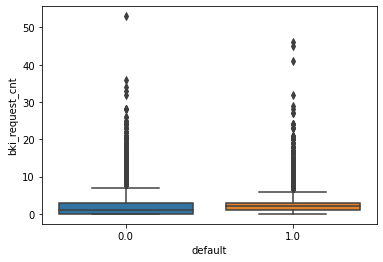

In [92]:
sns.boxplot(x='default', y='bki_request_cnt', data=data[data['Train'] == 1])

Дефолтные клиенты в среднем имеют больше запросов в БКИ. Также переведем этот признак в категориальный.

In [93]:
# Значения равные больше двух объединим в одну категорию

def bki_request_cnt_to_cat(x):
    if x <= 2:
        return x
    else:
        return 3


data['bki_request_cnt'] = data['bki_request_cnt'].apply(bki_request_cnt_to_cat)

**income**

<AxesSubplot:xlabel='default', ylabel='income'>

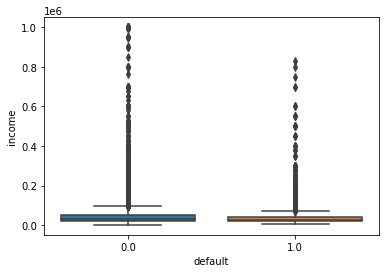

In [94]:
sns.boxplot(x='default', y='income', data=data[data['Train'] == 1])

Дефолтные клиенты в среднем имеют более низкий доход.<br>
Избавление от выбросов не показало улучшения метрики, поэтому оставим как есть.

**score_bki**

<AxesSubplot:xlabel='default', ylabel='score_bki'>

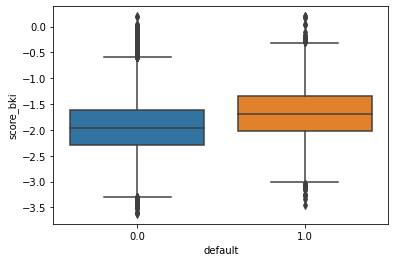

In [95]:
sns.boxplot(x='default', y='score_bki', data=data[data['Train'] == 1])

Дефолтные клиенты в среднем имеют более высокую отрицательную оценку. <br>
И здесь избавление от выбросов в этом признаке не показало улучшения метрики, поэтому здесь также оставим как есть.

## **Категориальные переменные**

**region_rating**

In [96]:
data['region_rating'].value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

In [97]:
# следующее преобразование позволило объединить непопулярные ответы между собой
def region_rating_change(x):
    if x <= 40:
        return 40
    else:
        return x


data['region_rating'] = data['region_rating'].apply(region_rating_change)

**education**

In [98]:
data['education'].value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [99]:
# еще одно преобразование позволило объединить непопулярные ответы между собой
def education_change(x):
    if x == 'SCH':
        return 1
    elif x == 'UGR':
        return 2
    else:
        return 3


data['education'] = data['education'].apply(education_change)

**app_date**

In [100]:
# из признака 'app_date' получаем день и месяц выдачи кредита
data['day'] = pd.to_datetime(data['app_date']).apply(lambda x: x.day)
data['month'] = pd.to_datetime(data['app_date']).apply(lambda x: x.month)

Преобразуем бинарные признаки:

In [101]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,Train,income_brc,income_dac,day,month
0,25905,01FEB2014,1,1,3,1,1,0,0,-2.008753,...,18000,4,1,0,0.0,1,9000.000000,18000.0,1,2
1,63161,12MAR2014,1,0,3,0,0,0,0,-1.532276,...,19000,4,1,0,0.0,1,4750.000000,19000.0,12,3
2,25887,01FEB2014,1,1,1,1,0,2,0,-1.408142,...,30000,1,4,1,0.0,1,15000.000000,10000.0,1,2
3,16222,23JAN2014,1,0,3,0,0,0,0,-2.057471,...,10000,1,3,0,0.0,1,3333.333333,10000.0,23,1
4,101655,18APR2014,3,1,2,0,0,0,1,-1.244723,...,30000,1,4,1,0.0,1,15000.000000,30000.0,18,4


### Значимость категориальных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn.

<AxesSubplot:>

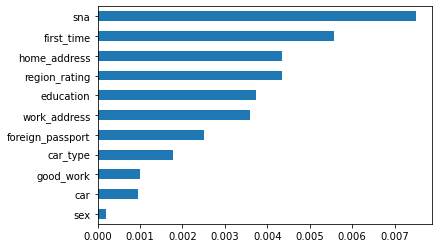

In [102]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols][data['Train'] == 1], data['default'][data['Train'] == 1],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Признак **'sna'** оказался самым важным из категориальных.

In [103]:
# добавим еще парочку новых признаков, которые улучшат нашу метрику:
data['income_region_rating'] = data['income']/(data['region_rating'])
data['income_sna'] = data['income']**(data['sna'])

In [104]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'home_address']
cat_cols = ['sna', 'home_address', 'region_rating', 'bki_request_cnt', 'month', 'education', 'work_address', 'first_time', 'age', 'decline_app_cnt']
num_cols = ['score_bki', 'income', 'income_dac', 'income_brc', 'day', 'income_region_rating', 'income_sna']

### Подготовка данных к машинному обучению

In [105]:
# создаем отдельную бинарную переменную для каждой категории
data = pd.get_dummies(data, columns = cat_cols)

In [106]:
# Стандартизация числовых переменных
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols].values))

## Обучение модели

Разделим нашу общую выборку на обучающую и тестовую, удалив признаки 'client_id' и 'app_date'. Первый признак не является информативным, а из второго признака мы уже получили нужную нам информацию.

In [107]:
X = data[data['Train'] == 1].drop(['Train','default'] , axis = 1).iloc[:,2:]
X_test = data[data['Train'] == 0].drop(['Train','default'], axis = 1).iloc[:,2:]
Y = data['default'].dropna()

In [108]:
# разобъем выборку на обучающую и валидационную:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

### Регуляризация

Перед обучением модели подберем гиперпараметры при помощи **GridSearchCV**.

In [109]:
model = LogisticRegression(random_state=RANDOM_SEED)
param_grid = [
    {'C' : np.logspace(0, 4, 10),
     'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'C' : np.logspace(0, 4, 10),
     'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'C' : np.logspace(0, 4, 10),
     'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']} 
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
print(best_parameters)

Таким образом, мы получили следующие оптимальные параметры: <br>
{'C': 2.7825594022071245, 'class_weight': 'balanced','penalty': 'l1', 'solver': 'liblinear'} <br>
Их и применим в нашей модели логистической регрессии.


In [110]:
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, C=2.7825594022071245, solver = 'liblinear', penalty = 'l1', class_weight = 'balanced')
lr.fit(X_train, y_train)
y_predict = lr.predict_proba(X_val)
roc_auc_score(y_val, y_predict[:,-1])

0.7467591698548592

## Оценка качества модели

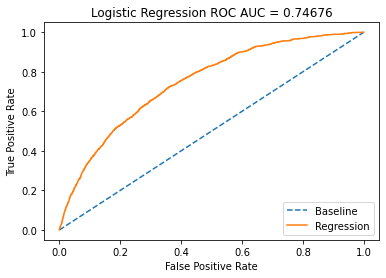

In [111]:
# Построим ROC-кривую:
fpr, tpr, threshold = roc_curve(y_val, y_predict[:,-1])
roc_auc = roc_auc_score(y_val, y_predict[:,-1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [112]:
# f1-score:
y_predict2 = lr.predict(X_val)
f1_score(y_val, y_predict2)

0.3407205982324949

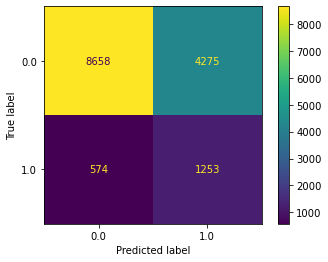

In [113]:
# confusion matrix
plot_confusion_matrix(lr, X_val, y_val)  
plt.show() 

## Submission

In [114]:
predict_submission = lr.predict_proba(X_test)

In [115]:
my_submission = pd.DataFrame(columns = ('client_id', 'default'))
my_submission['client_id'] = data_test['client_id']
my_submission['default'] = predict_submission[:,1]
my_submission.to_csv('submission.csv', index=False)
my_submission.head(10)

,client_id,default
0,74835,0.230992
1,17527,0.769127
2,75683,0.337537
3,26883,0.379853
4,28862,0.124475
5,99881,0.510497
6,26630,0.800701
7,79934,0.227430
8,16605,0.143720
9,105449,0.122183


## Выводы

Результатом выполнения данной работы стало:
    
* Разведывательный анализ данных с визуализацией.
* Включение новых признаков, повышающих значение метрики.
* Преобразование некоторых численных признаков в категориальные с улучшением метрики.
* Преобразования категориальных признаков.
* Подбор параметров регуляризации для нашей модели логистической регрессии.
* Обучение модели и получение значения метрик классификации, в числе которых ROC AUC для соревнования.
* Участие в соревновании на Kaggle и вхождение в 20% лучших результатов на момент публикования своего результата.